In [1]:
import numpy as np
import pandas as pd
import os
import sys
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import random
import joblib
import math
import ast
import logging
from msig import Motif, NullModel
from config import RESULTS_MOTIF_DIR, RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, TOWNSHIP_NAME, VARIABLES, NORMALIZE_FLAGS, STUMPY_EXCL_ZONE_DENOM, TOP_K_MP, INCLUDE, NORMALIZE, SUBSQUENCES_LENGTHS, NTOP_MOTIFS, MOTIF_SIZE
from config import LOOKBACK_PERIOD, STEP, FORECAST_PERIOD

optuna.logging.set_verbosity(optuna.logging.WARNING)

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")


if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

2025-02-05 17:33:07,502 - INFO - Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
2025-02-05 17:33:07,503 - INFO - Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
2025-02-05 17:33:07,503 - INFO - Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity


Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity


In [2]:
mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)
mp_stats_table = mp_stats_table[mp_stats_table["m"] == MOTIF_SIZE]
top_motifs = mp_stats_table.sort_values(by=["#Matches", "ID"], ascending=[False, True]).head(NTOP_MOTIFS)
top_motifs = top_motifs[["m", "Indices"]]

In [3]:
# read csv
data_df = pd.read_csv(
    DATASET_PATH,
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)

data_df = data_df[data_df["township_name"] == TOWNSHIP_NAME]
#set index to one_time and township_name
data_df = data_df.set_index(["one_time", "township_name"]).sort_index()[VARIABLES]
data = data_df.to_numpy().T
data_univar = data[0]
data_df

,,sum_terminals
one_time,township_name,
2021-09-15 00:00:00,Avenidas Novas,260700.0
2021-09-15 01:00:00,Avenidas Novas,276675.0
2021-09-15 02:00:00,Avenidas Novas,284563.0
2021-09-15 03:00:00,Avenidas Novas,279563.0
2021-09-15 04:00:00,Avenidas Novas,281460.0
...,...,...
2021-11-30 19:00:00,Avenidas Novas,391367.0
2021-11-30 20:00:00,Avenidas Novas,352361.0
2021-11-30 21:00:00,Avenidas Novas,388246.0


In [4]:
# Set global style for scientific plots
plt.rcParams.update({
    "font.family": "serif",  # Use a serif font for better readability in papers
    "font.size": 14,         # Increase font size for clarity
    "axes.titlesize": 16,    # Larger title font size
    "axes.labelsize": 14,    # Axis label size
    "xtick.labelsize": 12,   # Tick size for x-axis
    "ytick.labelsize": 12,   # Tick size for y-axis
    "legend.fontsize": 12,   # Legend font size
    "figure.figsize": (6, 4) # Standard paper figure size
})

for i, row in top_motifs.iterrows():
    motif_indices = sorted(ast.literal_eval(row["Indices"]))

    # Get the motif subsequences and Z-normalize them
    motif_subsequences = []
    for indice in motif_indices:
        seq = data_univar[indice:indice + MOTIF_SIZE]
        if len(seq) == MOTIF_SIZE:  # Ensure valid motif length
            norm_seq = (seq - np.mean(seq)) / np.std(seq)
            motif_subsequences.append(norm_seq)

    if not motif_subsequences:
        print(f"Skipping motif {i} due to empty subsequences.")
        continue

    motif_subsequences = np.array(motif_subsequences)

    # Create subplots with better spacing
    fig, axs = plt.subplots(2, 1, figsize=(6, 4), dpi=300, constrained_layout=True)

    # Plot normalized motif subsequences
    axs[0].plot(motif_subsequences.T, color="black", alpha=0.5, linewidth=1)
    axs[0].set_title("Normalized Motif Subsequences", fontsize=16)
    axs[0].set_xlabel("Time", fontsize=14)
    axs[0].set_ylabel("Normalized Value", fontsize=14)
    axs[0].grid(True, linestyle="--", alpha=0.5)

    # Plot original time series with motif locations
    axs[1].plot(data_univar, color="black", alpha=0.7, linewidth=1.5)
    for indice in motif_indices:
        axs[1].axvline(x=indice, color="red", linestyle="--", linewidth=1.2, alpha=0.8, label="Motif Occurrence" if indice == motif_indices[0] else "")
    axs[1].set_title("Original Time Series", fontsize=16)
    axs[1].set_xlabel("Time", fontsize=14)
    axs[1].set_ylabel("Value", fontsize=14)
    axs[1].grid(True, linestyle="--", alpha=0.5)

    # Add legend for clarity
    axs[1].legend(loc="upper right", frameon=True)

    # Save as high-quality PNG or PDF for publication
    plt.savefig(IMAGES_DIR / f"top_motif_{i}.png", dpi=300, bbox_inches="tight")
    plt.savefig(IMAGES_DIR / f"top_motif_{i}.pdf", bbox_inches="tight")  # Optional PDF for papers
    plt.close()


In [5]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


Evaluating motif 26 with size 12 and 58  indexes
X_series shape: torch.Size([1173, 504, 1])
X_indices shape: torch.Size([1173, 18, 1])
X_mask shape: torch.Size([1173, 504])
y shape: torch.Size([1173, 1])
Best epoch: 39
Test Loss: 91.26252746582031, Test MAE: 5.9660210609436035, Test RMSE: 9.553142547607422
Best hyperparameters: {'learning_rate': 0.0008246834848520056, 'kernel_size': 7, 'receptive_field': 250, 'dropout': 0.3630397922521945, 'batch_size': 8, 'block_channels_0': 16, 'block_channels_1': 32, 'block_channels_2': 32, 'block_channels_3': 16, 'block_channels_4': 32, 'block_channels_5': 16}
Early stopping at epoch 50, with best epoch being 39


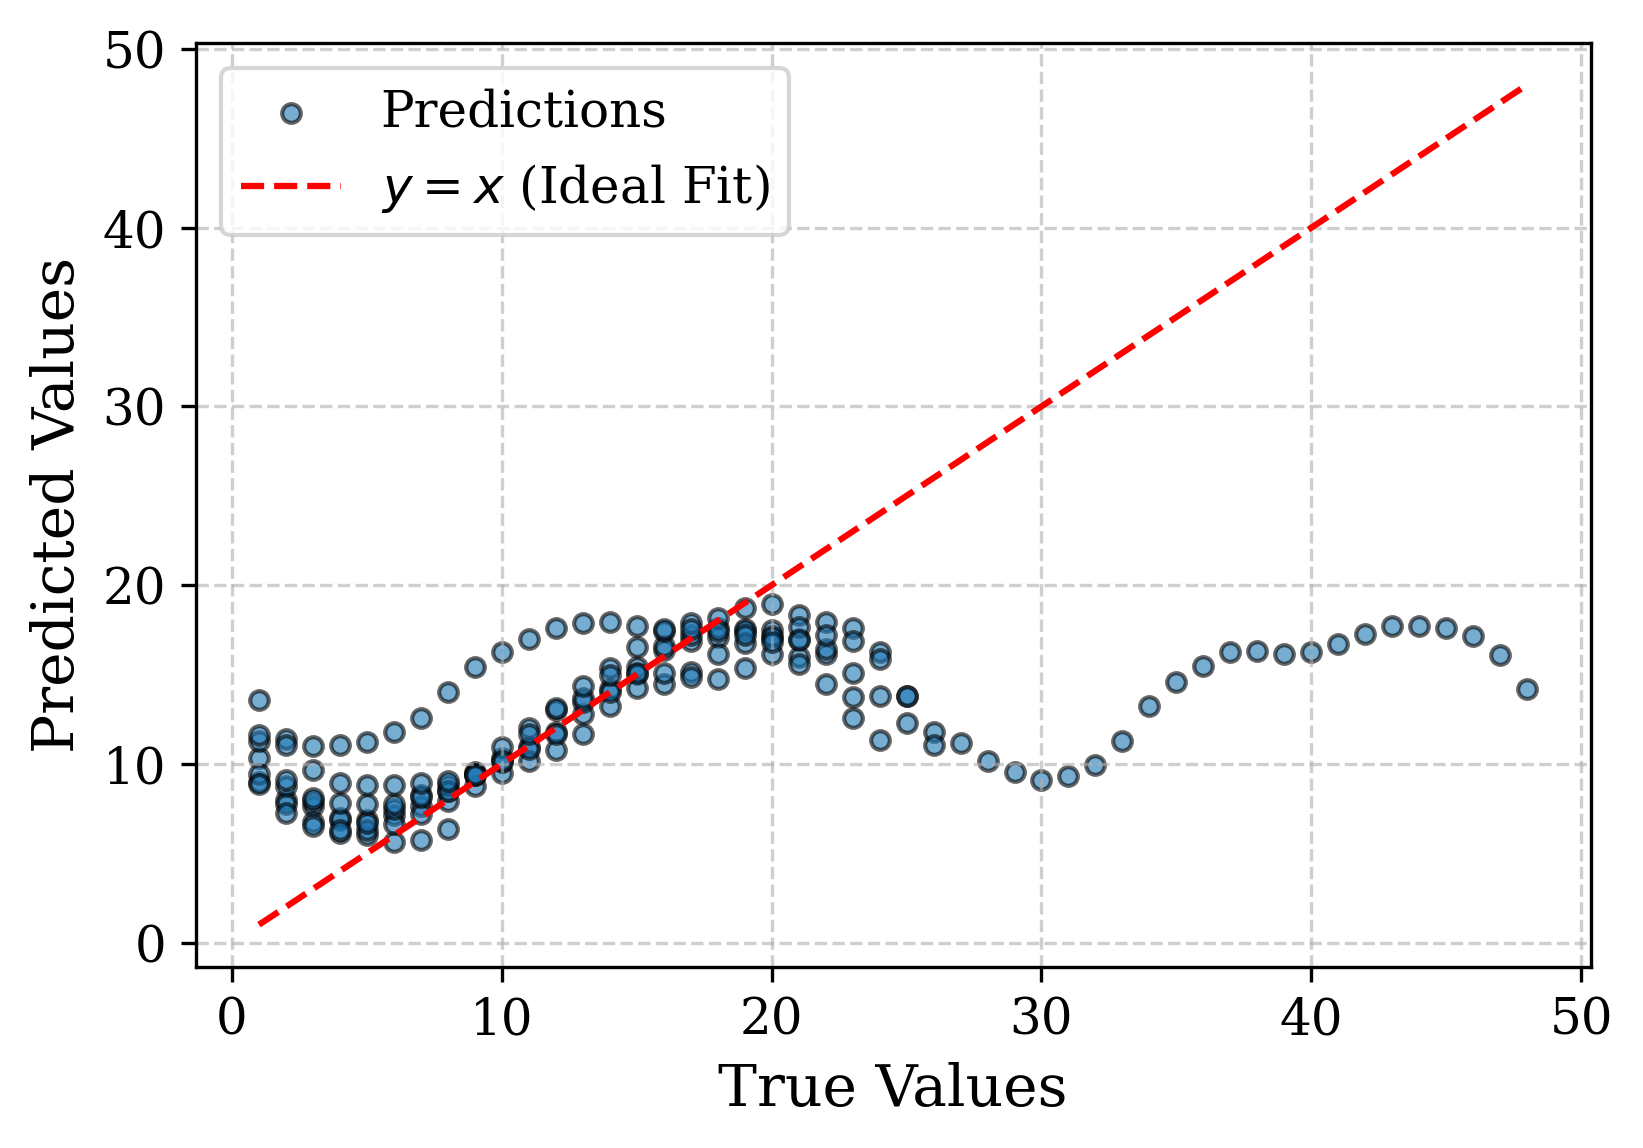

Evaluating motif 5 with size 12 and 47  indexes
X_series shape: torch.Size([1032, 504, 1])
X_indices shape: torch.Size([1032, 16, 1])
X_mask shape: torch.Size([1032, 504])
y shape: torch.Size([1032, 1])
Best epoch: 15
Test Loss: 95.36923217773438, Test MAE: 7.861830711364746, Test RMSE: 9.765717506408691
Best hyperparameters: {'learning_rate': 0.000416966602484927, 'kernel_size': 5, 'receptive_field': 250, 'dropout': 0.4298237127099697, 'batch_size': 8, 'block_channels_0': 32, 'block_channels_1': 32, 'block_channels_2': 32, 'block_channels_3': 32, 'block_channels_4': 32, 'block_channels_5': 32}
Early stopping at epoch 26, with best epoch being 15


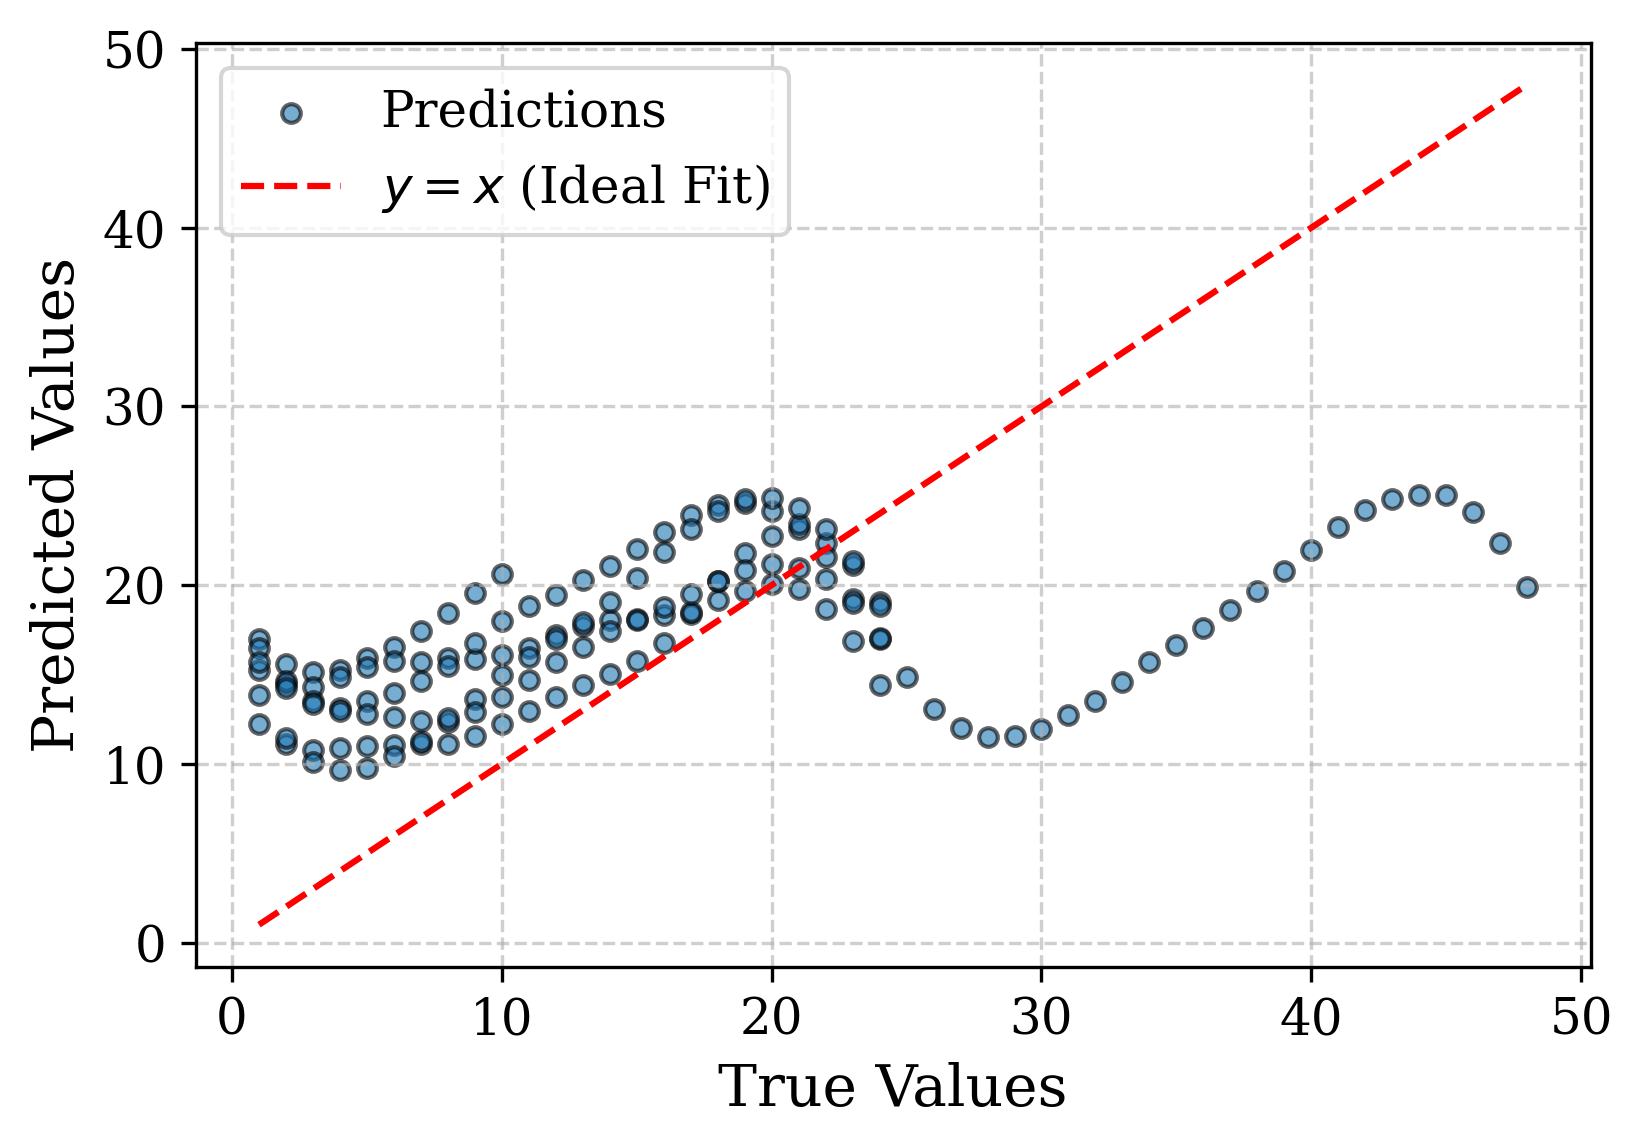

Evaluating motif 23 with size 12 and 46  indexes
X_series shape: torch.Size([1122, 504, 1])
X_indices shape: torch.Size([1122, 16, 1])
X_mask shape: torch.Size([1122, 504])
y shape: torch.Size([1122, 1])
Best epoch: 39
Test Loss: 116.86637878417969, Test MAE: 9.39499282836914, Test RMSE: 10.81047534942627
Best hyperparameters: {'learning_rate': 0.0008651418376476339, 'kernel_size': 5, 'receptive_field': 250, 'dropout': 0.48971605761371934, 'batch_size': 8, 'block_channels_0': 32, 'block_channels_1': 32, 'block_channels_2': 16, 'block_channels_3': 32, 'block_channels_4': 16, 'block_channels_5': 32}
Early stopping at epoch 50, with best epoch being 39


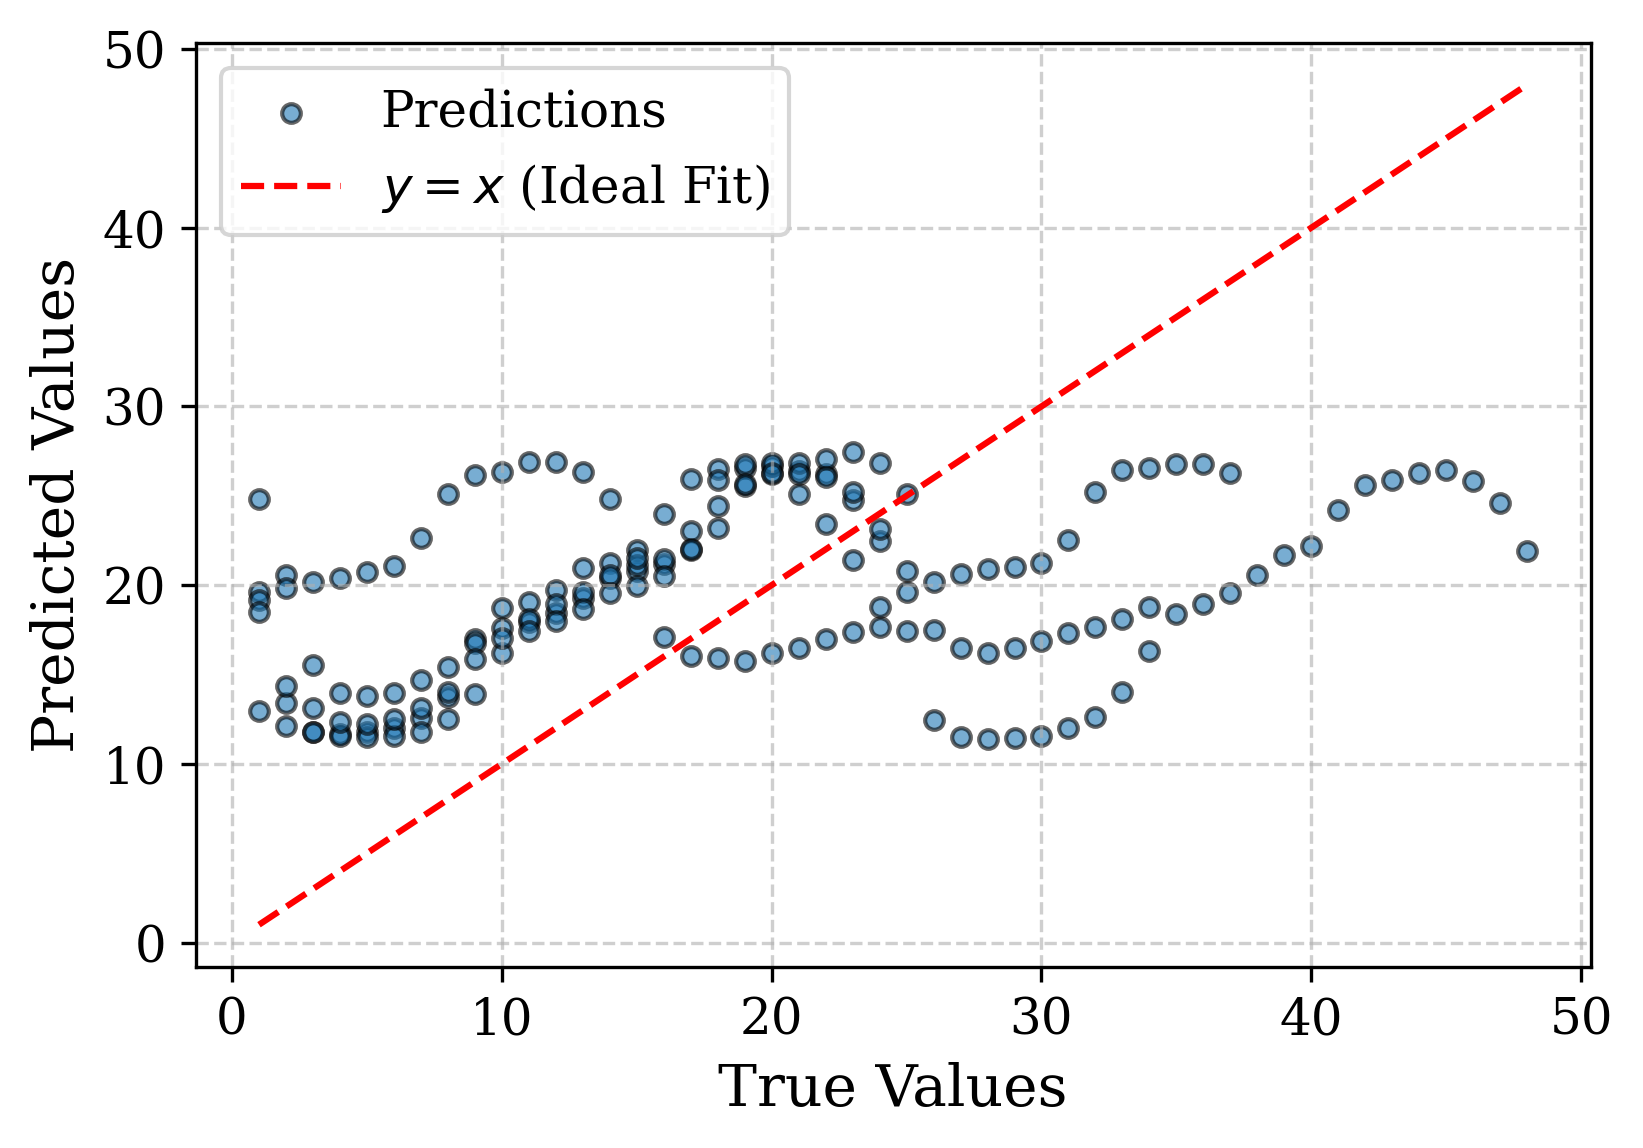

Evaluating motif 11 with size 12 and 44  indexes
X_series shape: torch.Size([1050, 504, 1])
X_indices shape: torch.Size([1050, 15, 1])
X_mask shape: torch.Size([1050, 504])
y shape: torch.Size([1050, 1])
Best epoch: 62
Test Loss: 190.8053436279297, Test MAE: 10.909411430358887, Test RMSE: 13.813230514526367
Best hyperparameters: {'learning_rate': 0.0006086605868415421, 'kernel_size': 3, 'receptive_field': 250, 'dropout': 0.1335207474281477, 'batch_size': 4, 'block_channels_0': 16, 'block_channels_1': 16, 'block_channels_2': 16, 'block_channels_3': 16, 'block_channels_4': 16, 'block_channels_5': 16, 'block_channels_6': 32}
Early stopping at epoch 73, with best epoch being 62


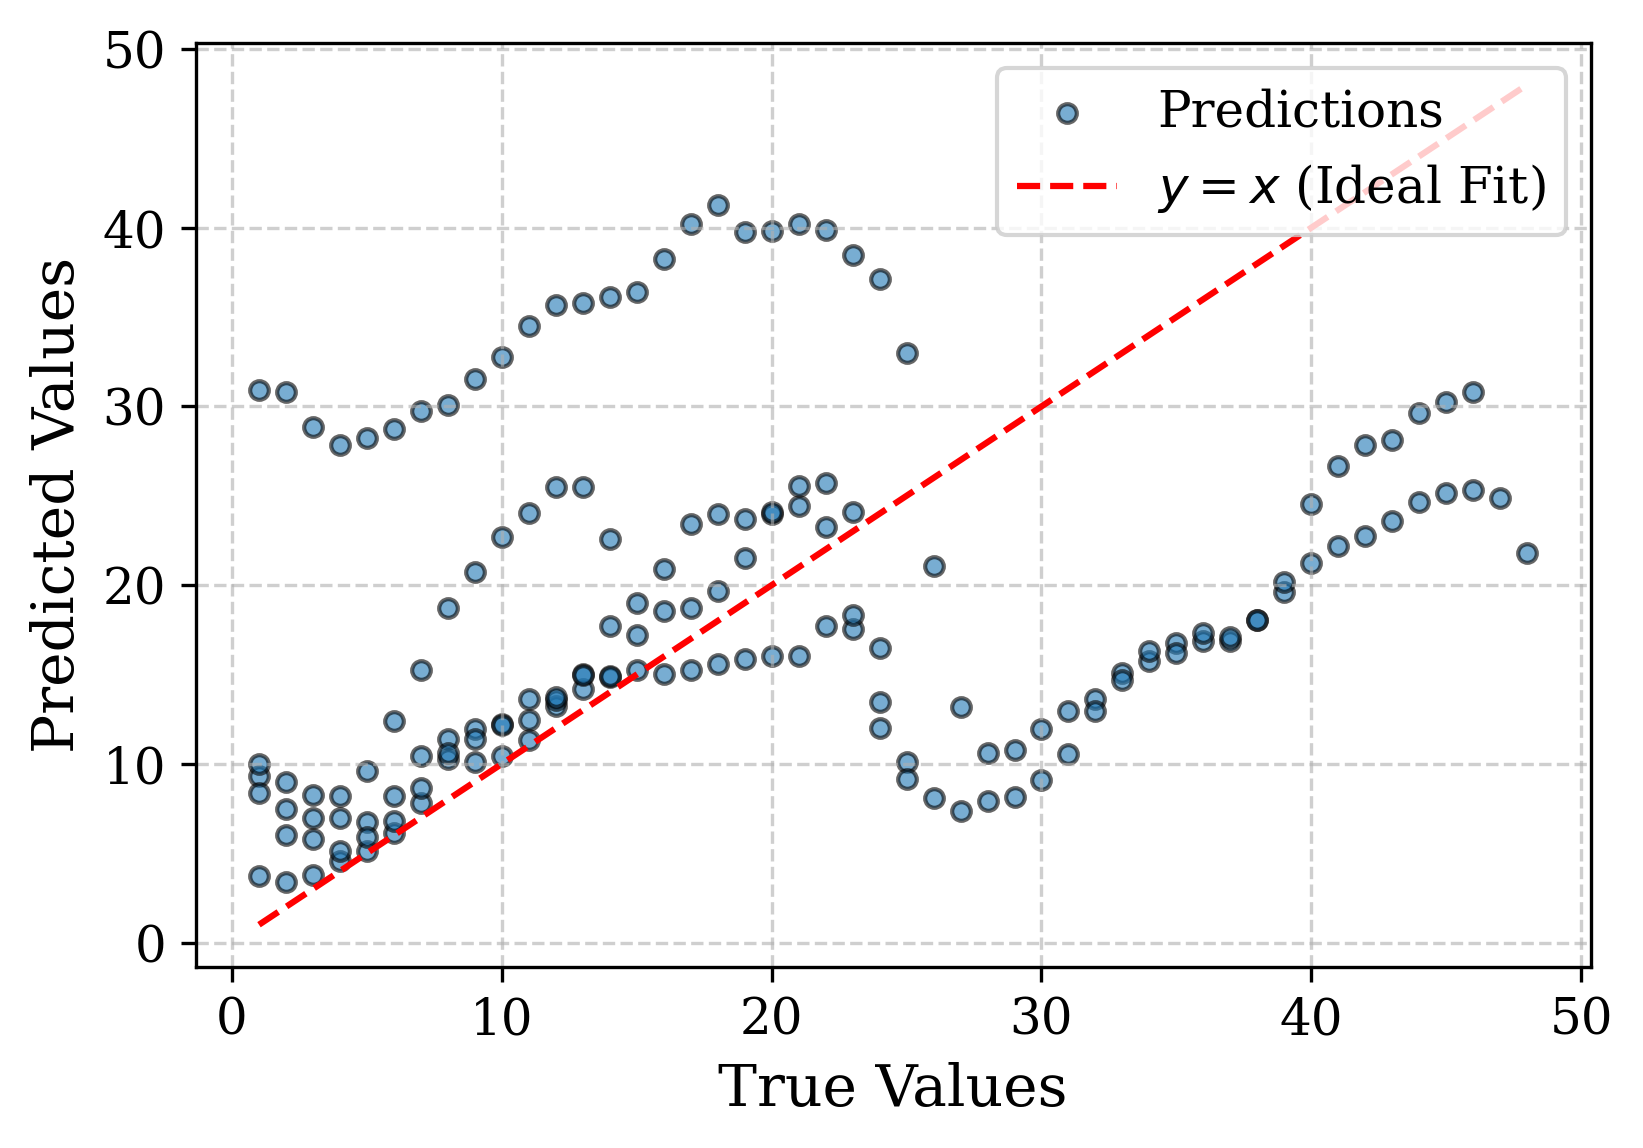

Evaluating motif 6 with size 12 and 38  indexes
X_series shape: torch.Size([979, 504, 1])
X_indices shape: torch.Size([979, 12, 1])
X_mask shape: torch.Size([979, 504])
y shape: torch.Size([979, 1])
Best epoch: 2
Test Loss: 184.64865112304688, Test MAE: 11.195491790771484, Test RMSE: 13.58854866027832
Best hyperparameters: {'learning_rate': 7.077670259640171e-05, 'kernel_size': 7, 'receptive_field': 250, 'dropout': 0.4289343168736275, 'batch_size': 16, 'block_channels_0': 32, 'block_channels_1': 16, 'block_channels_2': 32, 'block_channels_3': 32, 'block_channels_4': 16, 'block_channels_5': 32}
Early stopping at epoch 13, with best epoch being 2


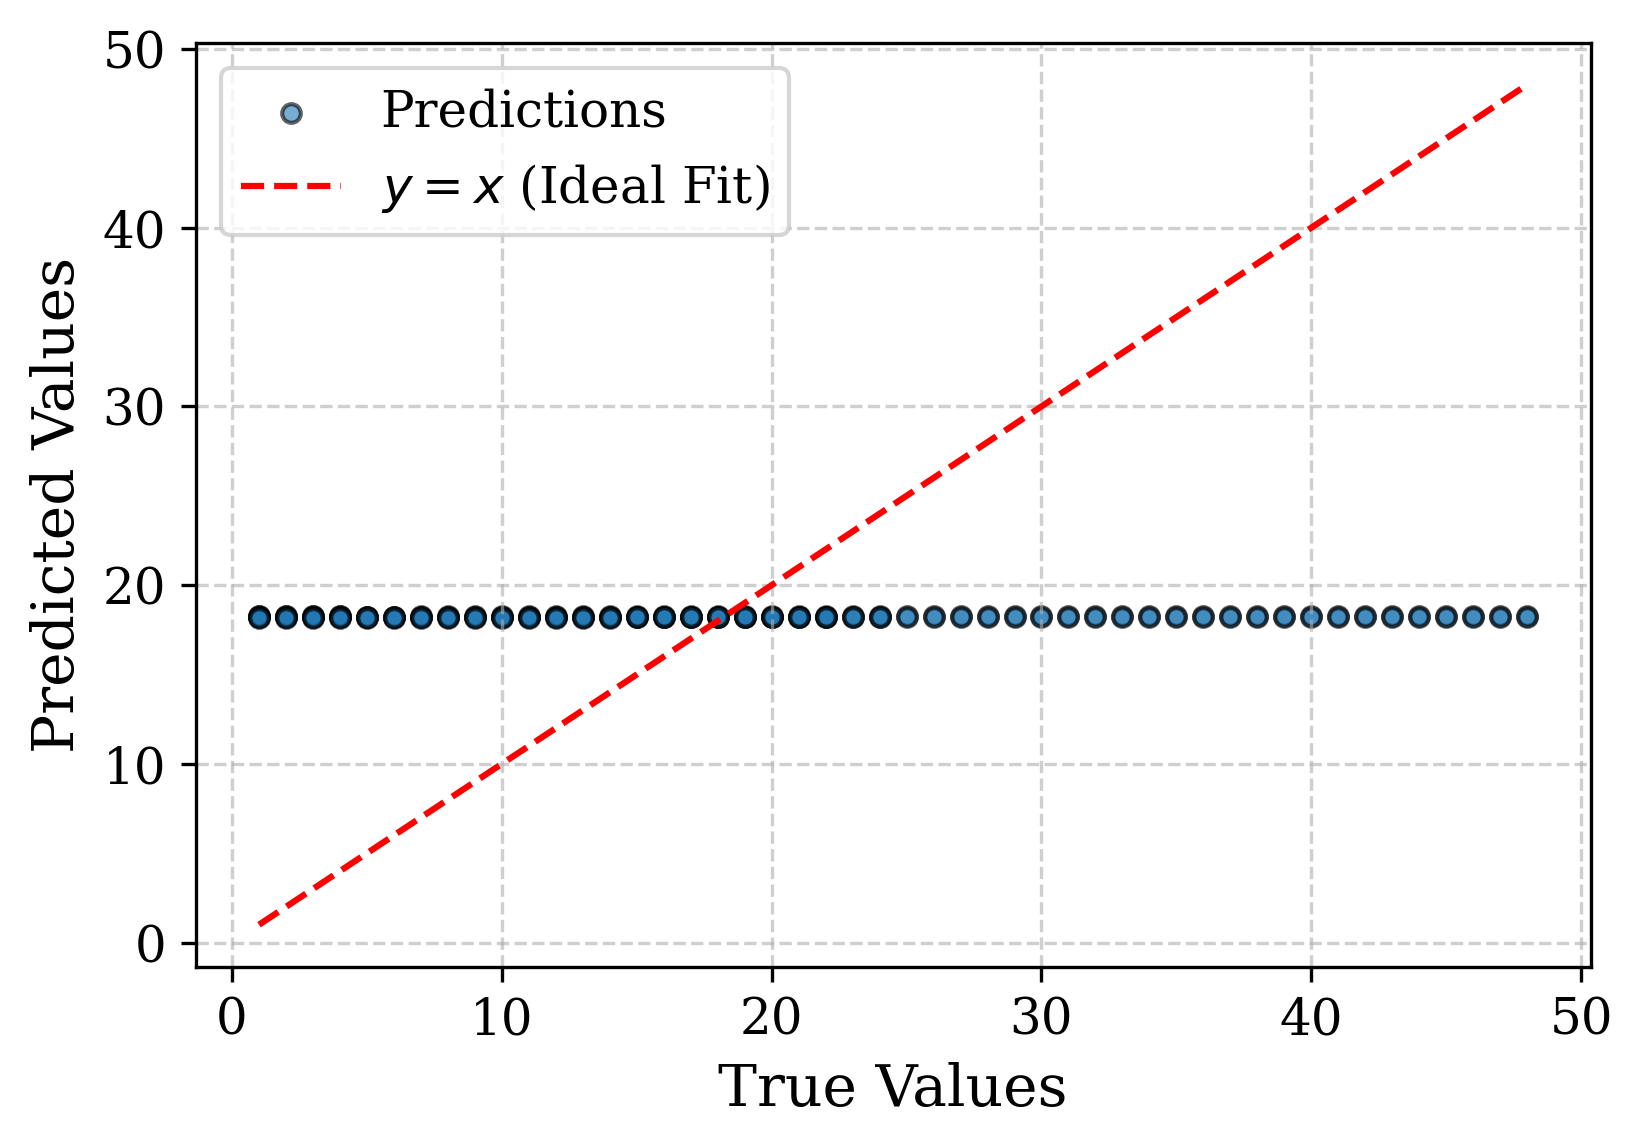

Aggregated Results Across Top 5 Motifs:
Mean Test Loss: 135.7904266357422 ± 43.33242099097667
Mean Test MAE: 9.065549564361572 ± 1.9545346941655193
Mean Test RMSE: 11.506222915649413 ± 1.8431663651202528


In [6]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.tcn_pytorch import TCN
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():

    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i} with size {MOTIF_SIZE} and {len(motif_indexes)}  indexes")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "TCN"
    model_name = "TCNSeries"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3],
            "kwargs": {"log": True}
        },
        "kernel_size": { # ensure receptive field is at least as large as sequence length (LOOKBACK_PERIOD)
            "type": "categorical",
            "args": [[3, 5 ,7]]
        },
        "receptive_field": {
            "type": "categorical",
            "args": [[250]]
        },
        "dropout": {
            "type": "float",
            "args": [0.0, 0.5]
        },
        "batch_size": {
            "type": "categorical",
            "args": [[4, 8, 16, 32]]
        }
    }


    model_params_keys = ["kernel_size", "num_channels_list", "dropout"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_series": X_series}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    #plot_best_model_results_traindevtest( study.trials_dataframe(),
    #    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    #)    
    plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i}_fold_{0}_predictions.pdf"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


In [7]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.tcn_pytorch import TCN
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

for i, top_motif in top_motifs.iterrows():

    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i} with size {MOTIF_SIZE} and {len(motif_indexes)}  indexes")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "TCN"
    model_name = "TCNSeries_Masking"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3],
            "kwargs": {"log": True}
        },
        "kernel_size": { # ensure receptive field is at least as large as sequence length (LOOKBACK_PERIOD)
            "type": "categorical",
            "args": [[3, 5 ,7]]
        },
        "receptive_field": {
            "type": "categorical",
            "args": [[250]]
        },
        "dropout": {
            "type": "float",
            "args": [0.0, 0.5]
        },
        "batch_size": {
            "type": "categorical",
            "args": [[4, 8, 16, 32]]
        }
    }

    model_params_keys = ["kernel_size", "num_channels_list", "dropout"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_series": X_series, "X_mask": X_mask}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type,suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    #epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    #plot_best_model_results_traindevtest( study.trials_dataframe(),
    #    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    #)    
    #plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


Evaluating motif 26 with size 12 and 58  indexes
X_series shape: torch.Size([1173, 504, 1])
X_indices shape: torch.Size([1173, 18, 1])
X_mask shape: torch.Size([1173, 504])
y shape: torch.Size([1173, 1])
Best epoch: 92
Test Loss: 109.81983947753906, Test MAE: 7.572815895080566, Test RMSE: 10.479496002197266
Evaluating motif 5 with size 12 and 47  indexes
X_series shape: torch.Size([1032, 504, 1])
X_indices shape: torch.Size([1032, 16, 1])
X_mask shape: torch.Size([1032, 504])
y shape: torch.Size([1032, 1])
Best epoch: 8
Test Loss: 145.9224395751953, Test MAE: 9.912907600402832, Test RMSE: 12.079835891723633
Evaluating motif 23 with size 12 and 46  indexes
X_series shape: torch.Size([1122, 504, 1])
X_indices shape: torch.Size([1122, 16, 1])
X_mask shape: torch.Size([1122, 504])
y shape: torch.Size([1122, 1])


FileNotFoundError: [Errno 2] No such file or directory: '/home/mgsilva/motifpred/results/populationdensity/TCNSeries_Masking_100_trials_500_epochs_motif_24/study.pkl'

In [ ]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.tcn_pytorch import TCN
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():

    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i+1} with size {MOTIF_SIZE} and {len(motif_indexes)}  indexes")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "TCN"
    model_name = "TCNIndices"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3],
            "kwargs": {"log": True}
        },
        "kernel_size": { # ensure receptive field is at least as large as sequence length (LOOKBACK_PERIOD)
            "type": "categorical",
            "args": [[3, 5 ,7]]
        },
        "receptive_field": {
            "type": "categorical",
            "args": [[250]]
        },
        "dropout": {
            "type": "float",
            "args": [0.0, 0.5]
        },
        "batch_size": {
            "type": "categorical",
            "args": [[4, 8, 16, 32]]
        }
    }

    model_params_keys = ["kernel_size", "num_channels_list", "dropout"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_indices": X_indices}
    run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type,suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    #epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    #plot_best_model_results_traindevtest( study.trials_dataframe(),
    #    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    #)    
    #plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")
